## Required packages

In [19]:
import numpy
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## train set extractor

In [7]:
def csv_extractor(file_name):

    csv_open = open(file_name,"r")
    feature_names = []
    labels = []

    for index, wave in enumerate(csv_open):
        wave = wave.strip("\n")
        wave = wave.split(",")
    
        feature = wave[0]
        label = wave[1]
        if index == 0:
            continue
    
        else:
            feature_names.append(feature)
            labels.append(label)

    feature_names = numpy.array(feature_names)
    labels = numpy.array(labels)
    
    return feature_names, labels
csv_train = csv_extractor("train.csv")

# test set extractor

In [8]:
def csv_extractor_test(file_name):

    csv_open = open(file_name,"r")
    
    feature_name_test = []

    for index, wave in enumerate(csv_open):
        wave = wave.strip("\n")

        feature = wave
        if index == 0:
            continue
    
        else:
            feature_name_test.append(feature)

    feature_name_test = numpy.array(feature_name_test)
    
    return feature_name_test

csv_test = csv_extractor_test("test.csv")

# Store train and test in an array 

In [9]:
feature_names, labels = csv_train
feature_name_test = csv_test

## checkpoint

In [10]:
print("len of train(features) examples:", feature_names.shape)
print("len of test examples",feature_name_test.shape)
print()
print("example of a file name:", feature_names[-1])
print("example of a label:", labels[-1])

len of train(features) examples: (94824,)
len of test examples (11005,)

example of a file name: 89717a535d5301648bd3ff1e4a3949922a38d22f.wav
example of a label: house


# step 1: Open our Dataset & Explore the structure of wave samples
- Okay, now that we have a list with all wave names and labels.
<br>
- Load wave file and visualize its waveform (using librosa)


In [26]:
cwd = os.getcwd()
my_path = cwd + "/mlchallenge-oct-2019/wav/wav/"

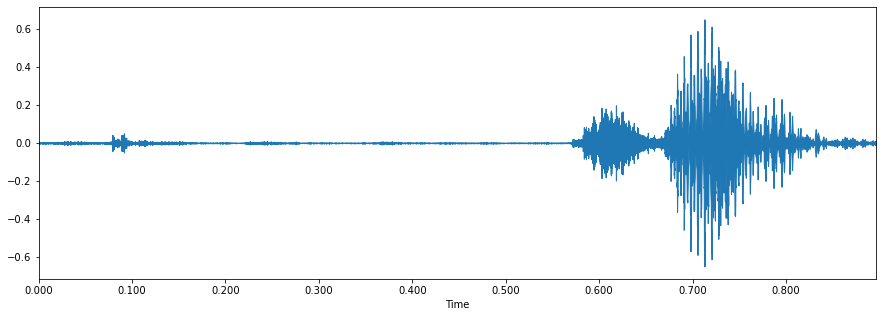

In [27]:
data, sampling_rate = librosa.load(my_path+'00000b653e96c0697676f91ec9dfb9fc9b4d085f.wav')

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# step 2: match feature_names with wave_files and extract MFCC features

- all_wave = folder with all wave files
- feature_names(numpy array) = name of all wave files
- labels(numpy array) = labels of all feature_names
- function will return features and labels

In [28]:
my_path_examples = []
for example in os.listdir(my_path):
    my_path_examples.append(example)
    
my_path_examples = numpy.array(my_path_examples)

## checkpoint

In [29]:
print("len of train(features) examples:", feature_names.shape)
print("len of train(labels) examples:", labels.shape)
print("len of train + test examples:", my_path_examples.shape)

len of train(features) examples: (94824,)
len of train(labels) examples: (94824,)
len of train + test examples: (105835,)


# MFCC feature extraction (train set)

In [31]:
def mfcc_features(my_path,feature_names, labels):
    features = []
    all_labels = []
    
    for (wave_name,label) in zip(feature_names,labels):
        
        for wave in os.listdir(my_path): 
            #if wav and wave_name are equal
            #extract mfcc features and append them to features
            #append label to labels
            if wave == wave_name:
                (rate,sig) = wav.read(my_path+wave)
                mfcc_feat = mfcc(sig,rate)
                
                features.append(mfcc_feat)
                all_labels.append(label)
                 
    features = numpy.array(features)
    all_labels = numpy.array(all_labels)
    
    return features, all_labels

mfcc_feat = mfcc_features(my_path, feature_names, labels)

C:\Users\voice\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# MFCC feature extraction (test set)

In [32]:
def mfcc_features_test(my_path,feature_names):

    all_features = []
    all_filename_test = []
    
    for wave_name in feature_names:
        
        for wave in os.listdir(my_path): 
            #if wav and wave_name are equal
            #extract mfcc features and append them to features
            if wave == wave_name: 
                (rate,sig) = wav.read(my_path+wave)
                mfcc_feat = mfcc(sig,rate)
                all_filename_test.append(wave)
                all_features.append(mfcc_feat)
                 
    all_features = numpy.array(all_features) 
    all_filename_test = numpy.array(all_filename_test)
    
    return all_features, all_filename_test

mfcc_feat_test = mfcc_features_test(my_path, feature_name_test)

C:\Users\voice\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## extract features and labels for train and test

In [33]:
MFCC_features, MFCC_labels = mfcc_feat
MFCC_features_test, MFCC_labels_test = mfcc_feat_test

## checkpoint

In [34]:
print("shape of extracted mfcc features from test set:", MFCC_features_test.shape)
print("shape of extracted mfcc features:", MFCC_features[0].shape)
print("shape of extracted mfcc labels:", MFCC_labels.shape)

shape of extracted mfcc features from test set: (11005,)
shape of extracted mfcc features: (99, 13)
shape of extracted mfcc labels: (94824,)


# zero pad function

In [35]:
def zero_pad(features):
    
    new_spoken_train = []
    max_shape = 0
    for x in features:
        all_shapes = x.shape[0]
        if all_shapes > max_shape:
            max_shape = all_shapes

    for x in features:
        difference = max_shape-x.shape[0]
        zero_padded = numpy.pad(x,((0,difference),(0,0)), "constant")
        new_spoken_train.append(zero_padded)

    new_spoken_train = numpy.array(new_spoken_train)
    
    return new_spoken_train

## zero pad MFCC features train set

In [36]:
new_spoken_train = zero_pad(MFCC_features)

## zero pad MFCC features test set

In [37]:
new_spoken_test = zero_pad(MFCC_features_test)

# checkpoint

In [38]:
print(new_spoken_train.shape)
print(new_spoken_test.shape)

(94824, 99, 13)
(11005, 99, 13)


# Apply standardization

In [39]:
new_spoken_train = numpy.reshape(new_spoken_train,(new_spoken_train.shape[0],1287))
new_spoken_test = numpy.reshape(new_spoken_test,(new_spoken_test.shape[0],1287))

In [40]:
scaler = StandardScaler()
scaler.fit(new_spoken_train)
new_spoken_train = scaler.fit_transform(new_spoken_train)
new_spoken_test = scaler.transform(new_spoken_test)

# Apply oversampling

In [41]:
ros = SMOTE(random_state=42)
new_mfcc_features,  mfcc_labels = ros.fit_resample(new_spoken_train, MFCC_labels)

dictionary_2 = {}
for i in mfcc_labels:
    dictionary_2[i] = dictionary_2.get(i,0) + 1

print(dictionary_2)

{'one': 3634, 'down': 3634, 'dog': 3634, 'three': 3634, 'forward': 3634, 'up': 3634, 'yes': 3634, 'stop': 3634, 'follow': 3634, 'seven': 3634, 'left': 3634, 'wow': 3634, 'eight': 3634, 'two': 3634, 'right': 3634, 'learn': 3634, 'no': 3634, 'happy': 3634, 'nine': 3634, 'zero': 3634, 'cat': 3634, 'visual': 3634, 'off': 3634, 'sheila': 3634, 'marvin': 3634, 'tree': 3634, 'four': 3634, 'bird': 3634, 'bed': 3634, 'on': 3634, 'go': 3634, 'five': 3634, 'six': 3634, 'backward': 3634, 'house': 3634}


# reshape 

In [42]:
new_mfcc_features = numpy.reshape(new_mfcc_features,(new_mfcc_features.shape[0],99,13))

# data overview

In [43]:
print(new_spoken_test.shape)
print(new_mfcc_features.shape)
print(mfcc_labels.shape)

(11005, 1287)
(127190, 99, 13)
(127190,)


# reshape

In [44]:
new_spoken_test = numpy.reshape(new_spoken_test,(new_spoken_test.shape[0],1287))
new_spoken_train = numpy.reshape(new_mfcc_features,(new_mfcc_features.shape[0],1287))

# One-hot encode Labels

In [48]:
def one_hot_encoder(labels):
    values = array(labels)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    return onehot_encoded

one_hot_encoded_labels = one_hot_encoder(mfcc_labels)

# import train_test_split and split data in train & val

In [49]:
X_train, X_test, y_train, y_test = train_test_split(new_spoken_train, 
                                                    one_hot_encoded_labels, 
                                                    test_size=0.33, 
                                                    random_state=42, 
                                                    stratify = one_hot_encoded_labels, 
                                                    shuffle= True)

## checkpoint

In [50]:
print(X_train.shape)
print(X_test.shape)

(85217, 1287)
(41973, 1287)


## reshape

In [51]:
X_train = numpy.reshape(X_train,(X_train.shape[0],99,13))
X_test = numpy.reshape(X_test,(X_test.shape[0],99,13))
print(X_train.shape)
print(X_test.shape)

(85217, 99, 13)
(41973, 99, 13)


## checkpoint

In [52]:
print("X_train shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (85217, 99, 13)
y_train shape: (85217, 35)
X_test shape: (41973, 99, 13)
y_test shape: (41973, 35)


# Build classification model: 1D CNN

In [53]:
model = Sequential()
model.add(Conv1D(128, 2, activation = "relu", input_shape=(99,13)))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(256, 2, activation = "relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.3))
model.add(Conv1D(356, 2, activation = "relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(456, 2, activation = "relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1048))
model.add(Dense(35, activation='softmax'))

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 128)           3456      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 256)           65792     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 356)           182628    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 356)           0

## train model

In [55]:
model.compile(loss= "categorical_crossentropy",
              optimizer= Adam(lr=0.0001),
              metrics=['accuracy'])

cnnhistory= model.fit(X_train, y_train,batch_size= 64, epochs= 60 ,validation_data=(X_test, y_test))

Epoch 1/60
1332/1332 [==============================] - 45s 34ms/step - loss: 1.6497 - accuracy: 0.5425 - val_loss: 0.8740 - val_accuracy: 0.7595
Epoch 2/60
1332/1332 [==============================] - 48s 36ms/step - loss: 0.8069 - accuracy: 0.7680 - val_loss: 0.6180 - val_accuracy: 0.8250
Epoch 3/60
1332/1332 [==============================] - 48s 36ms/step - loss: 0.6305 - accuracy: 0.8166 - val_loss: 0.5081 - val_accuracy: 0.8557
Epoch 4/60
1332/1332 [==============================] - 47s 35ms/step - loss: 0.5401 - accuracy: 0.8413 - val_loss: 0.4726 - val_accuracy: 0.8637
Epoch 5/60
1332/1332 [==============================] - 47s 35ms/step - loss: 0.4818 - accuracy: 0.8588 - val_loss: 0.4201 - val_accuracy: 0.8784
Epoch 6/60
1332/1332 [==============================] - 46s 35ms/step - loss: 0.4392 - accuracy: 0.8703 - val_loss: 0.3984 - val_accuracy: 0.8850
Epoch 7/60
1332/1332 [==============================] - 46s 35ms/step - loss: 0.4030 - accuracy: 0.8800 - val_loss: 0.3682 -

## result after training

In [56]:
result = model.evaluate(X_test, y_test)
print("validation accuracy:", result[1])

1312/1312 [==============================] - 6s 5ms/step - loss: 0.2884 - accuracy: 0.9418
validation accuracy: 0.9417721033096313


# plot loss and accuracy

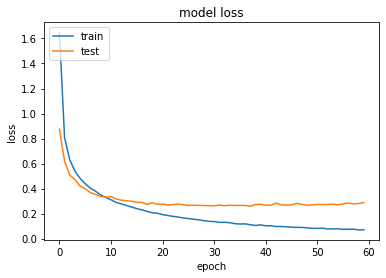

In [57]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

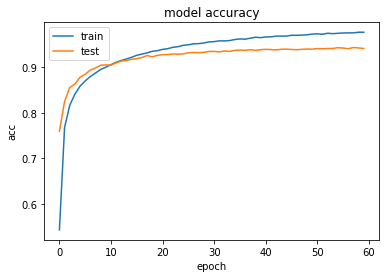

In [60]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN prediction output

In [61]:
new_spoken_test = numpy.reshape(new_spoken_test,(11005,99,13))

In [91]:
file_open = open("result.csv","a+")
for index in range(11005):
    file_name = MFCC_labels_test[index]
    predicted_word = label_encoder.inverse_transform([argmax(model.predict(new_spoken_test)[index, :])])
    predicted_word = "'".join(predicted_word)
    print(predicted_word)
    file_open.write(file_name+","+predicted_word+"\n")
    
file_open.close()

six
cat
seven
no
off
stop
five
three
one
two
three
five
no
five
marvin
eight
off
stop
house
on
house
three
right
right
tree
down
no
stop
five
nine
six
no
marvin
right
off
go
off
follow
stop
four
right
cat
down
no
eight
four
right
zero
eight
eight
bed
down
house
nine
off
four
five
zero
five
five
marvin
yes
eight
left
right
off
six
three
nine
two
yes
one
yes
on
bird
down
marvin
up
six
off
five
up
dog
on
left
five
seven
eight
five
right
stop
one
marvin
forward
bed
right
down
up
stop
visual
left
zero
down
house
eight
down
six
nine
three
eight
three
seven
happy
one
follow
seven
eight
nine
eight
wow
three
sheila
eight
nine
on
on
two
follow
stop
six
cat
up
house
learn
eight
up
up
go
six
tree
five
seven
down
sheila
on
up
four
two
off
down
no
one
two
dog
stop
four
stop
zero
off
stop
up
one
go
no
stop
one
right
four
backward
sheila
six
go
two
four
six
up
three
go
backward
eight
eight
two
cat
go
sheila
follow
no
two
seven
three
dog
follow
no
eight
nine
seven
five
on
go
four
forward
six
off
off
ha

left
two
visual
bed
seven
two
six
seven
marvin
go
bed
backward
right
tree
eight
happy
off
four
follow
no
bed
tree
house
wow
down
yes
five
tree
right
four
left
no
dog
wow
stop
five
four
yes
left
two
yes
tree
on
left
eight
tree
four
house
eight
off
left
dog
stop
happy
three
five
right
up
three
go
forward
stop
eight
dog
right
right
down
two
stop
yes
backward
sheila
zero
seven
down
right
two
left
happy
yes
stop
up
two
eight
five
no
six
nine
eight
zero
zero
right
eight
house
go
marvin
marvin
no
five
left
sheila
down
visual
three
on
no
bed
yes
six
visual
two
three
seven
four
house
bed
left
off
learn
seven
two
bird
left
learn
up
bed
seven
zero
six
on
five
yes
seven
yes
backward
left
nine
nine
four
go
stop
cat
learn
three
stop
right
bird
zero
sheila
six
two
happy
nine
nine
six
follow
happy
no
marvin
yes
down
five
one
left
down
on
eight
two
yes
two
on
yes
bird
seven
eight
right
yes
go
bed
two
three
bed
no
five
down
go
tree
sheila
on
on
nine
nine
right
one
five
no
left
eight
zero
dog
sheila
eigh

yes
four
three
forward
zero
go
left
one
marvin
stop
wow
bed
four
bird
yes
six
sheila
two
go
right
on
on
no
go
stop
down
right
off
left
dog
nine
three
off
six
right
four
four
sheila
one
eight
down
right
yes
visual
down
six
wow
dog
zero
visual
off
yes
three
up
on
one
off
yes
three
on
eight
no
yes
off
tree
nine
learn
nine
zero
stop
four
yes
bird
up
off
four
nine
left
two
zero
yes
wow
seven
cat
bed
off
marvin
go
stop
go
off
zero
off
one
nine
no
on
seven
yes
bed
five
follow
yes
zero
up
up
up
go
eight
up
cat
one
nine
right
three
up
two
down
eight
nine
stop
tree
follow
go
six
left
five
stop
nine
four
three
three
nine
five
go
eight
up
sheila
six
five
stop
right
seven
stop
six
go
two
down
go
eight
right
yes
stop
on
six
eight
left
cat
seven
eight
dog
cat
tree
seven
zero
bed
six
bed
two
go
cat
no
two
stop
two
follow
happy
zero
nine
eight
no
off
happy
eight
no
on
zero
zero
sheila
house
on
right
one
backward
on
sheila
zero
down
left
stop
two
two
go
wow
five
down
yes
one
four
seven
on
go
no
nine
dow

wow
seven
zero
eight
follow
eight
left
five
dog
stop
three
down
visual
two
seven
eight
down
up
stop
left
up
six
up
zero
down
sheila
no
tree
on
left
bed
eight
house
go
tree
stop
cat
three
one
visual
yes
tree
three
up
right
two
nine
two
three
stop
happy
six
go
two
sheila
nine
up
two
seven
stop
down
yes
down
three
four
follow
six
two
bed
zero
yes
no
eight
two
up
right
left
three
yes
one
six
no
zero
nine
left
dog
no
follow
cat
five
no
yes
off
down
visual
wow
two
bed
go
go
go
seven
dog
sheila
go
seven
two
backward
marvin
wow
learn
two
marvin
five
left
cat
five
stop
stop
four
cat
dog
zero
backward
seven
off
bird
forward
stop
down
four
eight
four
one
go
zero
visual
zero
sheila
four
visual
right
off
three
nine
bird
bird
five
six
tree
yes
one
two
three
go
sheila
happy
cat
four
go
yes
five
backward
nine
yes
go
six
left
wow
three
off
bird
yes
five
stop
five
one
zero
right
up
backward
eight
seven
house
on
two
one
cat
one
two
two
zero
cat
six
one
right
three
house
wow
five
backward
happy
six
three


cat
marvin
wow
no
right
three
bed
off
bird
yes
happy
up
off
stop
right
on
learn
wow
left
right
left
dog
five
zero
visual
visual
on
zero
seven
zero
five
yes
eight
follow
down
two
no
one
four
three
zero
no
backward
one
two
four
five
three
eight
happy
four
zero
forward
bed
on
zero
five
off
two
two
up
cat
on
on
left
right
right
stop
house
yes
happy
seven
no
stop
seven
five
forward
eight
one
yes
eight
seven
down
go
down
stop
up
no
nine
stop
bed
house
wow
eight
nine
bird
visual
three
right
off
follow
five
seven
one
left
visual
up
happy
off
dog
nine
left
off
no
stop
house
go
three
no
nine
off
follow
follow
cat
right
no
wow
up
zero
up
one
down
off
happy
eight
down
visual
eight
seven
down
sheila
right
stop
up
right
five
sheila
four
dog
visual
bed
two
six
house
stop
follow
right
yes
zero
go
bird
visual
tree
tree
bed
left
off
learn
right
five
left
on
zero
cat
zero
dog
two
on
right
up
zero
seven
nine
no
cat
happy
visual
right
house
up
right
left
one
right
four
cat
bird
follow
six
one
up
go
right
s

left
bed
five
on
one
eight
on
forward
wow
stop
eight
yes
stop
six
five
left
two
up
five
on
no
seven
follow
marvin
zero
six
nine
follow
six
yes
on
yes
down
bird
two
yes
four
no
down
six
bird
nine
two
five
cat
right
sheila
sheila
zero
down
one
left
follow
up
nine
dog
go
yes
up
yes
zero
down
visual
on
bird
yes
six
six
five
seven
stop
seven
bed
stop
one
seven
one
yes
tree
down
right
two
bed
yes
left
three
nine
three
two
left
eight
left
cat
two
four
six
zero
right
three
yes
eight
stop
up
one
right
yes
learn
seven
left
down
seven
nine
four
six
go
cat
zero
marvin
no
backward
eight
five
four
four
two
five
wow
eight
down
left
cat
stop
happy
four
learn
three
six
two
three
three
three
on
stop
dog
forward
zero
yes
sheila
on
yes
no
learn
dog
visual
off
down
right
learn
zero
left
stop
up
left
on
eight
happy
three
down
stop
cat
nine
house
right
up
stop
visual
house
off
zero
six
go
off
zero
down
up
two
one
one
one
right
nine
yes
backward
zero
sheila
follow
stop
visual
sheila
stop
five
eight
four
six
f

on
cat
zero
seven
four
four
forward
dog
on
forward
up
six
follow
dog
seven
sheila
on
sheila
backward
seven
zero
off
no
wow
go
five
eight
no
marvin
happy
two
happy
zero
visual
up
left
on
one
yes
off
yes
on
zero
bed
zero
up
no
three
tree
cat
zero
two
no
stop
two
five
follow
nine
two
left
zero
yes
house
four
no
left
five
wow
wow
nine
three
backward
nine
nine
four
one
yes
four
left
dog
seven
on
four
tree
yes
nine
right
nine
seven
go
yes
off
seven
three
on
happy
no
five
eight
yes
three
left
two
two
sheila
learn
nine
eight
marvin
right
right
sheila
right
off
bird
go
sheila
two
left
yes
forward
two
on
eight
forward
six
left
bird
yes
eight
five
bed
no
off
two
bird
right
nine
nine
go
three
eight
left
cat
seven
off
marvin
stop
down
bed
on
down
on
go
backward
five
up
wow
three
one
house
on
down
seven
up
seven
tree
nine
zero
tree
six
on
up
off
happy
two
one
seven
nine
two
four
stop
yes
two
on
one
cat
forward
five
five
stop
zero
left
follow
zero
wow
four
down
up
learn
wow
forward
dog
eight
happy
ni